## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [15]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

cv2.destroyAllWindows()

m_pipeline_control = {'sobel_threshold': [15, 50],
                    'color_threshold': [215, 255]}

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = [0]    
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([0])]  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([0])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        self.radius_of_curvature_m = 0 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        self.line_pts = [0]



In [17]:
class Pipeline():
    def __init__(self):
        # Create two lines
        self.l_line = Line()
        self.r_line = Line()
        self.current_frame = []
        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
        self.M = []
        self.Minv = [] 
        self.mtx=[]
        self.perspective_src = []
        self.perspective_dst = []
        self.distance_from_centre_m = 0
        self.dist =[]
        self.calibrate()
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension


    def push_frame(self, frame):
        # Add frame to pipeline
        self.current_frame = frame
    
    # Pipeline 
    def undistort(self, frame, plot_enabled = False):
        dst = cv2.undistort(frame, self.mtx, self.dist, None, self.mtx)
        return dst.astype(np.uint8)
    
    def binary(self, img, sobel_threshold = [20, 55], color_threshold = [220, 255], plot_enabled = False):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
    
        # Sobel x
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
        # Threshold x gradient
        thresh_min = sobel_threshold[0]
        thresh_max = sobel_threshold[1]
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
        # Threshold color channels
        s_thresh_min = color_threshold[0]
        s_thresh_max = color_threshold[1]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
        l_thresh_min = color_threshold[0]
        l_thresh_max = color_threshold[1]
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
        
        # Combine the three binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (l_binary == 1) | (sxbinary == 1)] = 255
        color_binary = np.dstack(( s_binary, l_binary, sxbinary)) * 255
        if plot_enabled:
            cv2.imwrite('color_binary.png', color_binary)
        return combined_binary.astype(np.uint8)
        
    def curvature_pixels_to_meters(self, leftx, rightx, y_eval, ploty):
        # Define conversions in x and y from pixels space to meters
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty, leftx, 2)
        right_fit_cr = np.polyfit(ploty, rightx, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Example values: 632.1 m    626.2 m
        return left_curverad, right_curverad
    
    def findline(self, binary_warped, plot_enabled = False):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if plot_enabled:  
            cv2.imwrite("lines_rectangles.png", out_img)
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Calculate curvature
        # Define conversions in x and y from pixels space to meters
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Sanity check line
        if (right_fitx[0] - left_fitx[0] < 500) or (right_fitx[0] - left_fitx[0] > 800)\
                or min(right_fitx - left_fitx) < 450:
            self.l_line.bestx = self.l_line.bestx
            self.r_line.bestx = self.r_line.bestx
        else:
            if len(self.l_line.bestx) == 1: # uninit
                self.l_line.bestx = left_fitx
                self.l_line.best_fit = left_fit
            else:
                self.l_line.bestx = self.l_line.bestx*0.8 + left_fitx*0.2
                self.l_line.best_fit = self.l_line.best_fit*0.8 + left_fit*0.2
            
            if len(self.r_line.bestx) == 1:# uninit
                self.r_line.bestx = right_fitx
                self.r_line.best_fit = right_fit
            else:
                self.r_line.bestx = self.r_line.bestx*0.8 + right_fitx*0.2
                self.r_line.best_fit = self.r_line.best_fit*0.8 + right_fit*0.2

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        if (np.size(self.l_line.bestx)==np.size(ploty) and np.size(self.l_line.bestx)==np.size(ploty)):
            plt.plot(self.l_line.bestx, ploty, color='yellow')
            plt.plot(self.r_line.bestx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        
        y_eval = np.max(ploty)
        #if len(self.l_line.best_fit)>1:
        self.l_line.radius_of_curvature = ((1 + (2*self.l_line.best_fit[0]*y_eval + self.l_line.best_fit[1])**2)**1.5) / np.absolute(2*self.l_line.best_fit[0])
        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, self.l_line.bestx*self.xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.l_line.radius_of_curvature_m = left_curverad
        #if len(self.r_line.best_fit)>1:
        self.r_line.radius_of_curvature = ((1 + (2*self.r_line.best_fit[0]*y_eval + self.r_line.best_fit[1])**2)**1.5) / np.absolute(2*self.r_line.best_fit[0])
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, self.r_line.bestx*self.xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        self.r_line.radius_of_curvature_m = right_curverad

    
        self.l_line.allx = leftx
        self.l_line.ally = lefty
        
        self.r_line.allx = rightx
        self.r_line.ally = righty

        return self.l_line.bestx, self.r_line.bestx, ploty

    def perspective_transform(self, binary_img, plot_enabled=False):
        """
        :param binary_img: Input image 
        :param plot: Show intermediate steps in plots
        :return: transformed image
        """
        from PIL import ImageDraw
        # Select region of interest
        vertices = np.array([[(0, 720),(480,450),(800,450),(1280,720)]], dtype=np.int32)
        masked_binary_region = region_of_interest(binary_img, vertices)
        if plot_enabled:
            plt.figure()
            plt.imshow(masked_binary_region)
            cv2.imwrite('masked_binary_region.png', masked_binary_region)   
            binary_region_with_mask = binary_img
            print(tuple(vertices[0][0][:]))
            cv2.line(binary_region_with_mask, tuple(vertices[0][0][:]), tuple(vertices[0][1][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][1][:]), tuple(vertices[0][2][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][2][:]), tuple(vertices[0][3][:]),(255,255,0),3)
            cv2.line(binary_region_with_mask, tuple(vertices[0][3][:]), tuple(vertices[0][0][:]),(255,255,0),3)
            plt.figure()
            plt.imshow(binary_region_with_mask)            
            cv2.imwrite('binary_region_with_mask.png', binary_region_with_mask)   

        binary_warped = cv2.warpPerspective(masked_binary_region, self.M, (1280,720))
        if plot_enabled:
            plt.figure()
            plt.imshow(binary_warped)
            cv2.imwrite('binary_warped.png', binary_warped)           
        if plot_enabled:
            
            # Create an image to draw the lines on
            warp_zero = np.zeros_like(binary_img).astype(np.uint8)

            cv2.line(warp_zero, tuple(self.perspective_src[0][:]), tuple(self.perspective_src[1][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[1][:]), tuple(self.perspective_src[2][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[2][:]), tuple(self.perspective_src[3][:]),(255,0,0),3)
            cv2.line(warp_zero, tuple(self.perspective_src[3][:]), tuple(self.perspective_src[0][:]),(255,0,0),3)
            # Recast the x and y points into usable format for cv2.fillPoly()
            result = cv2.addWeighted(binary_img, 1, warp_zero, 0.3, 0)
            f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,9))
            newwarp = cv2.warpPerspective(result, self.M, (1280, 720)) 
            ax1.imshow(result)
            ax2.imshow(newwarp)
        
        left_fitx, right_fitx, ploty = self.findline(binary_warped, plot_enabled = plot_enabled)
        
        if (self.r_line.detected):
            right_fitx = self.r_line.best_fit
        if (self.l_line.detected):
            left_fitx = self.l_line.best_fit  
            
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (1280, 720)) 
        # Combine the result with the original image
        result = cv2.addWeighted(self.current_frame, 1, newwarp, 0.3, 0)
        if plot_enabled:
            plt.figure()
            plt.imshow(result)
            cv2.imwrite('with_lines.png', result)  
            
        # Calculate distance from centre
            print(left_fitx[-1])
            print(right_fitx[-1])
            print(left_fitx[0])
            print(right_fitx[0])            
        self.distance_from_centre_m = -((left_fitx[-1] - (1280 - right_fitx[-1]))) * self.xm_per_pix
        
        return result

    
    def calibrate(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')
        
        gray = []
        # Step through the list and search for chessboard corners
        
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
            # If found, add object points, image points
            if ret:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
        
                # Draw and display the corners

        img_size = [1280, 720]
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        src = np.float32([[585, 460],[203, 720],[1127,720],[695,460]])
        dst = np.float32([[320, 0 ],[320, 720],[960, 720],[960, 0]])        
        self.perspective_src = src
        self.perspective_dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)  
        assert(np.shape(gray) == (720,1280))
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, np.shape(gray), None, None)
        img = cv2.imread('camera_cal/calibration1.jpg')
        undistorded = cv2.undistort(img, self.mtx, self.dist)
        cv2.imwrite('undistorted_chessboard.png',undistorded)

        
    def pipeline(self, frame, pipeline_control = m_pipeline_control, plot_enabled = False):
        self.current_frame = frame
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('distorted.png', frame) 
        frame = self.undistort(frame, plot_enabled = plot_enabled)
        self.current_frame = frame
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('undistorted.png', frame)        
        frame = self.binary(frame, 
                            sobel_threshold=pipeline_control['sobel_threshold'], 
                            color_threshold=pipeline_control['color_threshold'],
                            plot_enabled = plot_enabled)
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('binary.png', frame)
        font                   = cv2.FONT_HERSHEY_SIMPLEX 
        bottomLeftCornerOfText = (200,200)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2            

        frame = self.perspective_transform(frame, plot_enabled = plot_enabled)
        cv2.putText(frame, 
                    'L/R curvature: {:0.0f}/{:0.0f} m * Distance from centre: {:0.2f} m'.format(
                        self.l_line.radius_of_curvature_m, 
                        self.r_line.radius_of_curvature_m, 
                        self.distance_from_centre_m),
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale, 
                    fontColor)   
        if plot_enabled:
            plt.figure()
            plt.imshow(frame)   
            cv2.imwrite('with_text.png', frame)         
        return frame.astype(np.uint8)




In [18]:
def region_of_interest(img, vertices, plot_enabled = False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    if plot_enabled:
        plt.figure()
        plt.imshow(img)
        cv2.imwrite('region_of_interest.png', img)
    return masked_image


## Pipeline will perform the rest of the operations on the video frames.


(0, 720)

fit

324.3217025952142

948.6414244234786

299.5839097505461

996.7917112459444

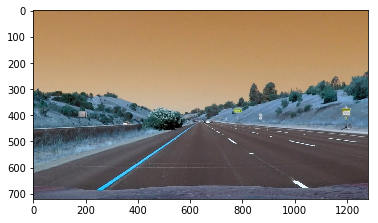

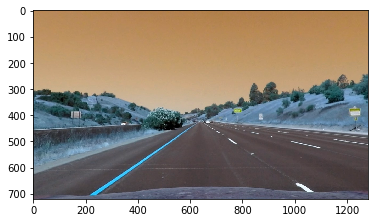

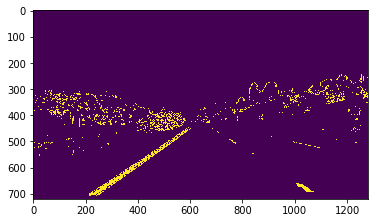

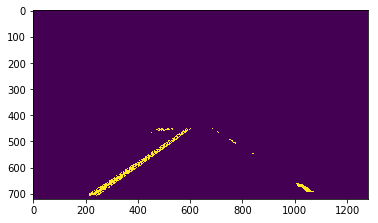

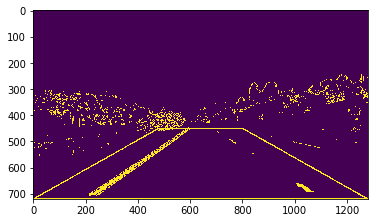

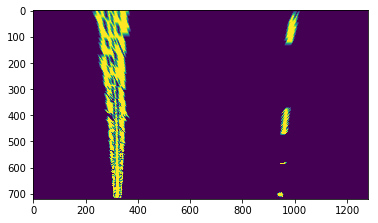

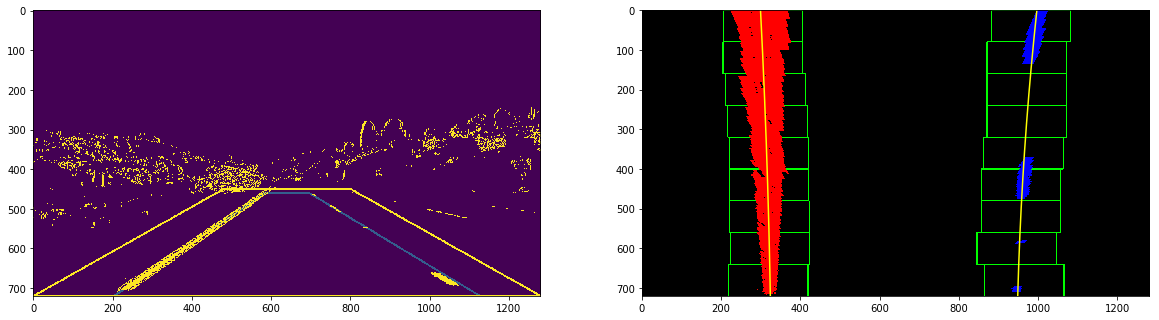

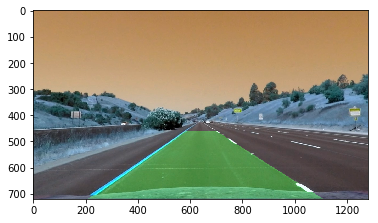

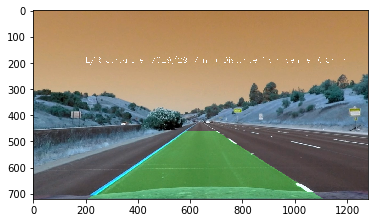

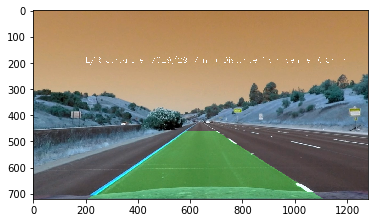

(0, 720)

fit

324.3217025952142

948.6414244234786

299.5839097505461

996.7917112459444

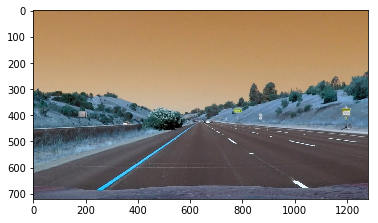

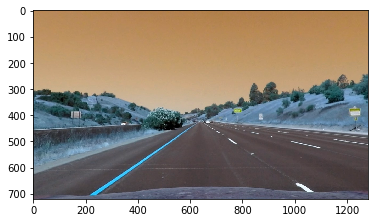

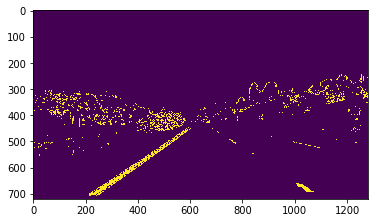

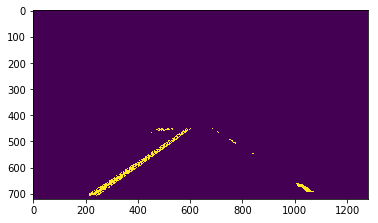

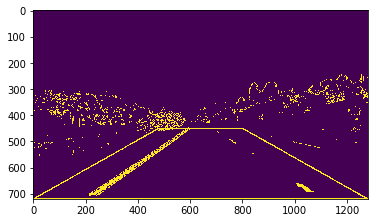

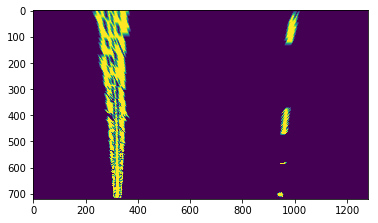

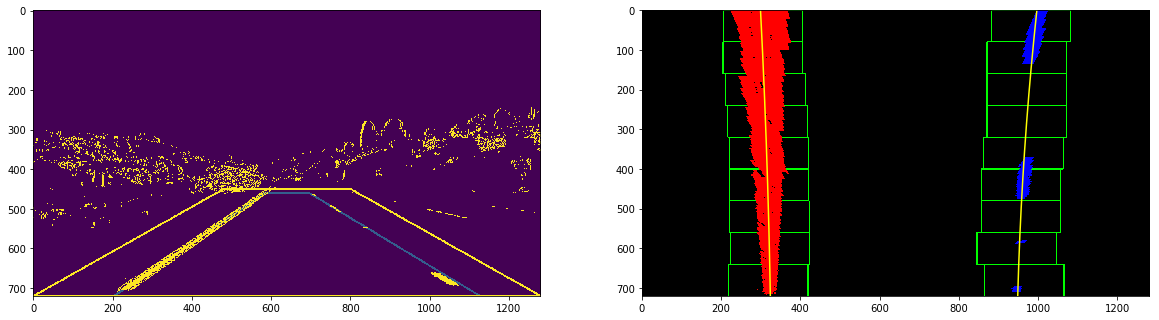

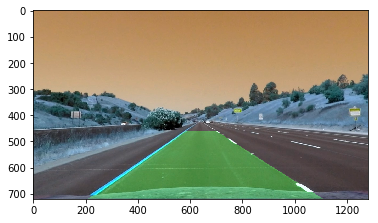

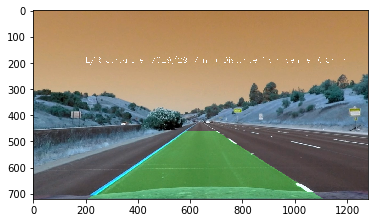

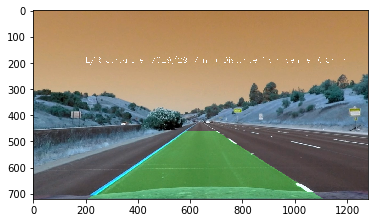

In [19]:
test_images = glob.glob('test_images_report/*.jpg')

pipe = Pipeline()
pipe.calibrate()

img = cv2.imread(test_images[0])

(0, 720)

fit

324.3217025952142

948.6414244234786

299.5839097505461

996.7917112459444

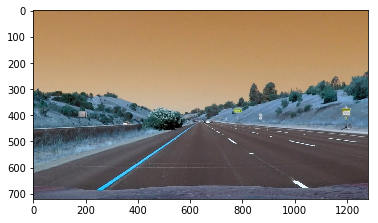

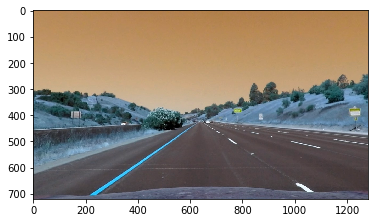

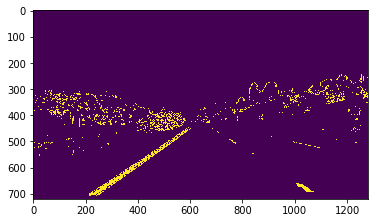

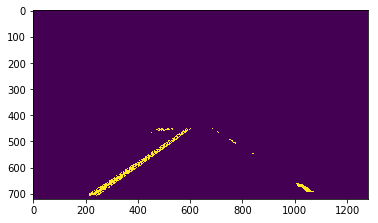

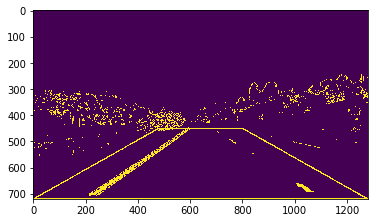

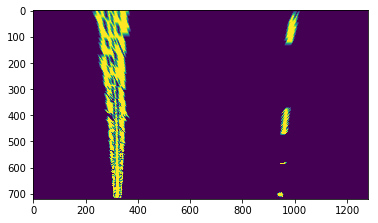

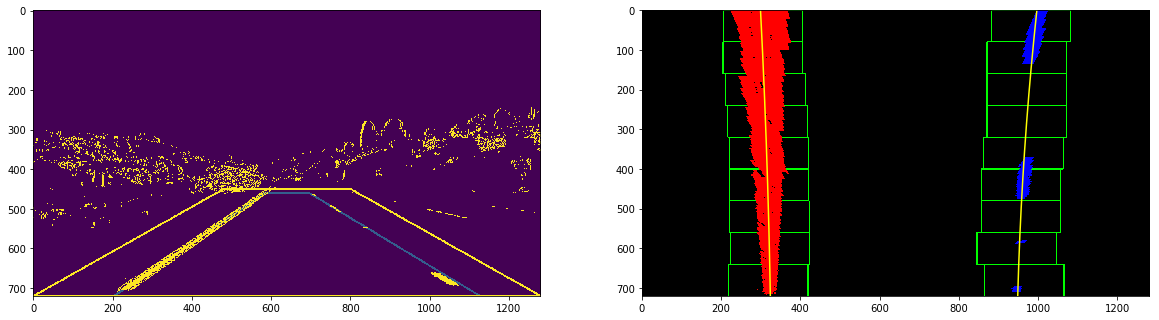

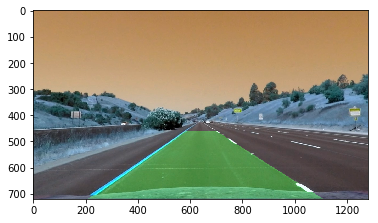

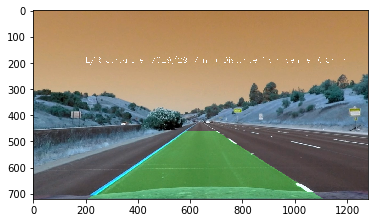

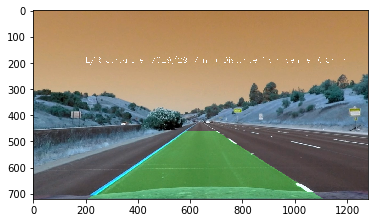

In [20]:
test_images = glob.glob('test_images_report/*.jpg')

#pipe = Pipeline()
#pipe.calibrate()
for img_file in test_images:
    img = cv2.imread(img_file)
    processed_image = pipe.pipeline(img, 
                                    pipeline_control=m_pipeline_control, 
                                    plot_enabled=True)
    
    plt.figure()
    plt.imshow(processed_image)   
    cv2.imwrite('final.png', processed_image)


cv2.destroyAllWindows()


In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip2 = VideoFileClip('project_video.mp4')#.subclip(40,43)
output_clip = 'project_video_result.mp4'
processed_clip = clip2.fl_image(pipe.pipeline)

%time processed_clip.write_videofile(output_clip, audio=False)


fit

[MoviePy] >>>> Building video project_video_result.mp4


[MoviePy] Writing video project_video_result.mp4


  0%|                                                                                                                                                                                                         | 0/1261 [00:00<?, ?it/s]

fit

  0%|▏                                                                                                                                                                                                | 1/1261 [00:00<03:32,  5.94it/s]

fit

  0%|▎                                                                                                                                                                                                | 2/1261 [00:00<03:32,  5.91it/s]

fit

  0%|▍                                                                                                                                                                                                | 3/1261 [00:00<03:25,  6.11it/s]

fit

  0%|▌                                                                                                                                                                                                | 4/1261 [00:00<03:23,  6.17it/s]

fit

  0%|▊                                                                                                                                                                                                | 5/1261 [00:00<03:23,  6.16it/s]

fit

  0%|▉                                                                                                                                                                                                | 6/1261 [00:00<03:25,  6.11it/s]

fit

  1%|█                                                                                                                                                                                                | 7/1261 [00:01<03:26,  6.09it/s]

fit

  1%|█▏                                                                                                                                                                                               | 8/1261 [00:01<03:27,  6.04it/s]

fit

  1%|█▍                                                                                                                                                                                               | 9/1261 [00:01<03:26,  6.06it/s]

fit

  1%|█▌                                                                                                                                                                                              | 10/1261 [00:01<03:25,  6.08it/s]

fit

  1%|█▋                                                                                                                                                                                              | 11/1261 [00:01<03:25,  6.07it/s]

fit

  1%|█▊                                                                                                                                                                                              | 12/1261 [00:02<03:28,  5.99it/s]

fit

  1%|█▉                                                                                                                                                                                              | 13/1261 [00:02<03:28,  5.99it/s]

fit

  1%|██▏                                                                                                                                                                                             | 14/1261 [00:02<03:28,  5.97it/s]

fit

  1%|██▎                                                                                                                                                                                             | 15/1261 [00:02<03:29,  5.94it/s]

fit

  1%|██▍                                                                                                                                                                                             | 16/1261 [00:02<03:29,  5.95it/s]

fit

  1%|██▌                                                                                                                                                                                             | 17/1261 [00:02<03:28,  5.96it/s]

fit

  1%|██▋                                                                                                                                                                                             | 18/1261 [00:03<03:27,  5.98it/s]

fit

  2%|██▉                                                                                                                                                                                             | 19/1261 [00:03<03:27,  5.99it/s]

fit

  2%|███                                                                                                                                                                                             | 20/1261 [00:03<03:26,  6.00it/s]

fit

  2%|███▏                                                                                                                                                                                            | 21/1261 [00:03<03:26,  6.01it/s]

fit

  2%|███▎                                                                                                                                                                                            | 22/1261 [00:03<03:25,  6.02it/s]

fit

  2%|███▌                                                                                                                                                                                            | 23/1261 [00:03<03:25,  6.03it/s]

fit

  2%|███▋                                                                                                                                                                                            | 24/1261 [00:03<03:25,  6.03it/s]

fit

  2%|███▊                                                                                                                                                                                            | 25/1261 [00:04<03:24,  6.04it/s]

fit

  2%|███▉                                                                                                                                                                                            | 26/1261 [00:04<03:24,  6.03it/s]

fit

  2%|████                                                                                                                                                                                            | 27/1261 [00:04<03:24,  6.03it/s]

fit

  2%|████▎                                                                                                                                                                                           | 28/1261 [00:04<03:24,  6.02it/s]

fit

  2%|████▍                                                                                                                                                                                           | 29/1261 [00:04<03:25,  5.98it/s]

fit

  2%|████▌                                                                                                                                                                                           | 30/1261 [00:05<03:26,  5.95it/s]

fit

  2%|████▋                                                                                                                                                                                           | 31/1261 [00:05<03:26,  5.97it/s]

fit

  3%|████▊                                                                                                                                                                                           | 32/1261 [00:05<03:25,  5.98it/s]

fit

  3%|█████                                                                                                                                                                                           | 33/1261 [00:05<03:25,  5.99it/s]

fit

  3%|█████▏                                                                                                                                                                                          | 34/1261 [00:05<03:24,  6.00it/s]

fit

  3%|█████▎                                                                                                                                                                                          | 35/1261 [00:05<03:24,  6.00it/s]

fit

  3%|█████▍                                                                                                                                                                                          | 36/1261 [00:06<03:24,  6.00it/s]

fit

  3%|█████▋                                                                                                                                                                                          | 37/1261 [00:06<03:23,  6.00it/s]

fit

  3%|█████▊                                                                                                                                                                                          | 38/1261 [00:06<03:23,  6.01it/s]

fit

  3%|█████▉                                                                                                                                                                                          | 39/1261 [00:06<03:24,  5.99it/s]

fit

  3%|██████                                                                                                                                                                                          | 40/1261 [00:06<03:24,  5.98it/s]

fit

  3%|██████▏                                                                                                                                                                                         | 41/1261 [00:06<03:24,  5.98it/s]

fit

  3%|██████▍                                                                                                                                                                                         | 42/1261 [00:07<03:23,  5.98it/s]

fit

  3%|██████▌                                                                                                                                                                                         | 43/1261 [00:07<03:24,  5.97it/s]

fit

  3%|██████▋                                                                                                                                                                                         | 44/1261 [00:07<03:23,  5.98it/s]

fit

  4%|██████▊                                                                                                                                                                                         | 45/1261 [00:07<03:22,  5.99it/s]

fit

  4%|███████                                                                                                                                                                                         | 46/1261 [00:07<03:22,  6.00it/s]

fit

  4%|███████▏                                                                                                                                                                                        | 47/1261 [00:07<03:22,  6.00it/s]

fit

  4%|███████▎                                                                                                                                                                                        | 48/1261 [00:07<03:21,  6.01it/s]

fit

  4%|███████▍                                                                                                                                                                                        | 49/1261 [00:08<03:21,  6.02it/s]

fit

  4%|███████▌                                                                                                                                                                                        | 50/1261 [00:08<03:21,  6.02it/s]

fit

  4%|███████▊                                                                                                                                                                                        | 51/1261 [00:08<03:21,  6.02it/s]

fit

  4%|███████▉                                                                                                                                                                                        | 52/1261 [00:08<03:20,  6.02it/s]

fit

  4%|████████                                                                                                                                                                                        | 53/1261 [00:08<03:20,  6.01it/s]

fit

  4%|████████▏                                                                                                                                                                                       | 54/1261 [00:08<03:20,  6.02it/s]

fit

  4%|████████▎                                                                                                                                                                                       | 55/1261 [00:09<03:20,  6.02it/s]

fit

  4%|████████▌                                                                                                                                                                                       | 56/1261 [00:09<03:20,  6.00it/s]

fit

  5%|████████▋                                                                                                                                                                                       | 57/1261 [00:09<03:21,  5.97it/s]

fit

  5%|████████▊                                                                                                                                                                                       | 58/1261 [00:09<03:22,  5.95it/s]

fit

  5%|████████▉                                                                                                                                                                                       | 59/1261 [00:09<03:22,  5.94it/s]

fit

  5%|█████████▏                                                                                                                                                                                      | 60/1261 [00:10<03:21,  5.95it/s]

fit

  5%|█████████▎                                                                                                                                                                                      | 61/1261 [00:10<03:21,  5.95it/s]

fit

  5%|█████████▍                                                                                                                                                                                      | 62/1261 [00:10<03:21,  5.94it/s]

fit

  5%|█████████▌                                                                                                                                                                                      | 63/1261 [00:10<03:21,  5.95it/s]

fit

  5%|█████████▋                                                                                                                                                                                      | 64/1261 [00:10<03:20,  5.96it/s]

fit

  5%|█████████▉                                                                                                                                                                                      | 65/1261 [00:10<03:20,  5.96it/s]

fit

  5%|██████████                                                                                                                                                                                      | 66/1261 [00:11<03:20,  5.97it/s]

fit

  5%|██████████▏                                                                                                                                                                                     | 67/1261 [00:11<03:19,  5.97it/s]

fit

  5%|██████████▎                                                                                                                                                                                     | 68/1261 [00:11<03:19,  5.98it/s]

fit

  5%|██████████▌                                                                                                                                                                                     | 69/1261 [00:11<03:19,  5.98it/s]

fit

  6%|██████████▋                                                                                                                                                                                     | 70/1261 [00:11<03:19,  5.98it/s]

fit

  6%|██████████▊                                                                                                                                                                                     | 71/1261 [00:11<03:19,  5.98it/s]

fit

  6%|██████████▉                                                                                                                                                                                     | 72/1261 [00:12<03:19,  5.97it/s]

fit

  6%|███████████                                                                                                                                                                                     | 73/1261 [00:12<03:19,  5.96it/s]

fit

  6%|███████████▎                                                                                                                                                                                    | 74/1261 [00:12<03:19,  5.95it/s]

fit

  6%|███████████▍                                                                                                                                                                                    | 75/1261 [00:12<03:19,  5.95it/s]

fit

  6%|███████████▌                                                                                                                                                                                    | 76/1261 [00:12<03:18,  5.96it/s]

fit

  6%|███████████▋                                                                                                                                                                                    | 77/1261 [00:12<03:18,  5.96it/s]

fit

  6%|███████████▉                                                                                                                                                                                    | 78/1261 [00:13<03:18,  5.97it/s]

fit

  6%|████████████                                                                                                                                                                                    | 79/1261 [00:13<03:17,  5.97it/s]

fit

  6%|████████████▏                                                                                                                                                                                   | 80/1261 [00:13<03:17,  5.97it/s]

fit

  6%|████████████▎                                                                                                                                                                                   | 81/1261 [00:13<03:17,  5.97it/s]

fit

  7%|████████████▍                                                                                                                                                                                   | 82/1261 [00:13<03:17,  5.97it/s]

fit

  7%|████████████▋                                                                                                                                                                                   | 83/1261 [00:13<03:17,  5.98it/s]

fit

  7%|████████████▊                                                                                                                                                                                   | 84/1261 [00:14<03:16,  5.98it/s]

fit

  7%|████████████▉                                                                                                                                                                                   | 85/1261 [00:14<03:16,  5.98it/s]

fit

  7%|█████████████                                                                                                                                                                                   | 86/1261 [00:14<03:16,  5.97it/s]

fit

  7%|█████████████▏                                                                                                                                                                                  | 87/1261 [00:14<03:16,  5.96it/s]

fit

  7%|█████████████▍                                                                                                                                                                                  | 88/1261 [00:14<03:16,  5.96it/s]

fit

  7%|█████████████▌                                                                                                                                                                                  | 89/1261 [00:14<03:16,  5.96it/s]

fit

  7%|█████████████▋                                                                                                                                                                                  | 90/1261 [00:15<03:16,  5.96it/s]

fit

  7%|█████████████▊                                                                                                                                                                                  | 91/1261 [00:15<03:16,  5.96it/s]

fit

  7%|██████████████                                                                                                                                                                                  | 92/1261 [00:15<03:16,  5.96it/s]

fit

  7%|██████████████▏                                                                                                                                                                                 | 93/1261 [00:15<03:15,  5.97it/s]

fit

  7%|██████████████▎                                                                                                                                                                                 | 94/1261 [00:15<03:15,  5.98it/s]

fit

  8%|██████████████▍                                                                                                                                                                                 | 95/1261 [00:15<03:14,  5.98it/s]

fit

  8%|██████████████▌                                                                                                                                                                                 | 96/1261 [00:16<03:14,  5.98it/s]

fit

  8%|██████████████▊                                                                                                                                                                                 | 97/1261 [00:16<03:14,  5.98it/s]

fit

  8%|██████████████▉                                                                                                                                                                                 | 98/1261 [00:16<03:14,  5.99it/s]

fit

  8%|███████████████                                                                                                                                                                                 | 99/1261 [00:16<03:14,  5.99it/s]

fit

  8%|███████████████▏                                                                                                                                                                               | 100/1261 [00:16<03:14,  5.98it/s]

fit

  8%|███████████████▎                                                                                                                                                                               | 101/1261 [00:16<03:14,  5.98it/s]

fit

  8%|███████████████▍                                                                                                                                                                               | 102/1261 [00:17<03:14,  5.97it/s]

fit

  8%|███████████████▌                                                                                                                                                                               | 103/1261 [00:17<03:13,  5.97it/s]

fit

  8%|███████████████▊                                                                                                                                                                               | 104/1261 [00:17<03:13,  5.97it/s]

fit

  8%|███████████████▉                                                                                                                                                                               | 105/1261 [00:17<03:13,  5.98it/s]

fit

  8%|████████████████                                                                                                                                                                               | 106/1261 [00:17<03:13,  5.98it/s]

fit

  8%|████████████████▏                                                                                                                                                                              | 107/1261 [00:17<03:12,  5.98it/s]

fit

  9%|████████████████▎                                                                                                                                                                              | 108/1261 [00:18<03:12,  5.99it/s]

fit

  9%|████████████████▌                                                                                                                                                                              | 109/1261 [00:18<03:12,  5.99it/s]

fit

  9%|████████████████▋                                                                                                                                                                              | 110/1261 [00:18<03:12,  5.99it/s]

fit

  9%|████████████████▊                                                                                                                                                                              | 111/1261 [00:18<03:12,  5.99it/s]

fit

  9%|████████████████▉                                                                                                                                                                              | 112/1261 [00:18<03:11,  5.99it/s]

fit

  9%|█████████████████                                                                                                                                                                              | 113/1261 [00:18<03:11,  6.00it/s]

fit

  9%|█████████████████▎                                                                                                                                                                             | 114/1261 [00:19<03:11,  6.00it/s]

fit

  9%|█████████████████▍                                                                                                                                                                             | 115/1261 [00:19<03:11,  5.99it/s]

fit

  9%|█████████████████▌                                                                                                                                                                             | 116/1261 [00:19<03:11,  5.99it/s]

fit

  9%|█████████████████▋                                                                                                                                                                             | 117/1261 [00:19<03:11,  5.99it/s]

fit

  9%|█████████████████▊                                                                                                                                                                             | 118/1261 [00:19<03:11,  5.98it/s]

fit

  9%|██████████████████                                                                                                                                                                             | 119/1261 [00:19<03:10,  5.98it/s]

fit

 10%|██████████████████▏                                                                                                                                                                            | 120/1261 [00:20<03:10,  5.99it/s]

fit

 10%|██████████████████▎                                                                                                                                                                            | 121/1261 [00:20<03:10,  5.99it/s]

fit

 10%|██████████████████▍                                                                                                                                                                            | 122/1261 [00:20<03:10,  5.99it/s]

fit

 10%|██████████████████▋                                                                                                                                                                            | 123/1261 [00:20<03:09,  5.99it/s]

fit

 10%|██████████████████▊                                                                                                                                                                            | 124/1261 [00:20<03:09,  5.99it/s]

fit

 10%|██████████████████▉                                                                                                                                                                            | 125/1261 [00:20<03:09,  5.99it/s]

fit

 10%|███████████████████                                                                                                                                                                            | 126/1261 [00:21<03:09,  5.99it/s]

fit

 10%|███████████████████▏                                                                                                                                                                           | 127/1261 [00:21<03:09,  5.99it/s]

fit

 10%|███████████████████▍                                                                                                                                                                           | 128/1261 [00:21<03:08,  6.00it/s]

fit

 10%|███████████████████▌                                                                                                                                                                           | 129/1261 [00:21<03:08,  6.00it/s]

fit

 10%|███████████████████▋                                                                                                                                                                           | 130/1261 [00:21<03:08,  5.99it/s]

fit

 10%|███████████████████▊                                                                                                                                                                           | 131/1261 [00:21<03:08,  5.99it/s]

fit

 10%|███████████████████▉                                                                                                                                                                           | 132/1261 [00:22<03:08,  5.99it/s]

fit

 11%|████████████████████▏                                                                                                                                                                          | 133/1261 [00:22<03:08,  5.98it/s]

fit

 11%|████████████████████▎                                                                                                                                                                          | 134/1261 [00:22<03:08,  5.98it/s]

fit

 11%|████████████████████▍                                                                                                                                                                          | 135/1261 [00:22<03:08,  5.99it/s]

fit

 11%|████████████████████▌                                                                                                                                                                          | 136/1261 [00:22<03:07,  5.99it/s]

fit

 11%|████████████████████▊                                                                                                                                                                          | 137/1261 [00:22<03:07,  5.99it/s]

fit

 11%|████████████████████▉                                                                                                                                                                          | 138/1261 [00:23<03:07,  5.99it/s]

fit

 11%|█████████████████████                                                                                                                                                                          | 139/1261 [00:23<03:07,  6.00it/s]

fit

 11%|█████████████████████▏                                                                                                                                                                         | 140/1261 [00:23<03:06,  6.00it/s]

fit

 11%|█████████████████████▎                                                                                                                                                                         | 141/1261 [00:23<03:06,  6.00it/s]

fit

 11%|█████████████████████▌                                                                                                                                                                         | 142/1261 [00:23<03:06,  6.00it/s]

fit

 11%|█████████████████████▋                                                                                                                                                                         | 143/1261 [00:23<03:06,  6.00it/s]

fit

 11%|█████████████████████▊                                                                                                                                                                         | 144/1261 [00:24<03:06,  6.00it/s]

fit

 11%|█████████████████████▉                                                                                                                                                                         | 145/1261 [00:24<03:06,  5.99it/s]

fit

 12%|██████████████████████                                                                                                                                                                         | 146/1261 [00:24<03:06,  5.99it/s]

fit

 12%|██████████████████████▎                                                                                                                                                                        | 147/1261 [00:24<03:06,  5.99it/s]

fit

 12%|██████████████████████▍                                                                                                                                                                        | 148/1261 [00:24<03:05,  5.99it/s]

fit

 12%|██████████████████████▌                                                                                                                                                                        | 149/1261 [00:24<03:05,  5.99it/s]

fit

 12%|██████████████████████▋                                                                                                                                                                        | 150/1261 [00:25<03:05,  5.99it/s]

fit

 12%|██████████████████████▊                                                                                                                                                                        | 151/1261 [00:25<03:05,  6.00it/s]

fit

 12%|███████████████████████                                                                                                                                                                        | 152/1261 [00:25<03:04,  6.00it/s]

fit

 12%|███████████████████████▏                                                                                                                                                                       | 153/1261 [00:25<03:04,  6.00it/s]

fit

 12%|███████████████████████▎                                                                                                                                                                       | 154/1261 [00:25<03:04,  6.00it/s]

fit

 12%|███████████████████████▍                                                                                                                                                                       | 155/1261 [00:25<03:04,  5.99it/s]

fit

 12%|███████████████████████▋                                                                                                                                                                       | 156/1261 [00:26<03:04,  6.00it/s]

fit

 12%|███████████████████████▊                                                                                                                                                                       | 157/1261 [00:26<03:04,  6.00it/s]

fit

 13%|███████████████████████▉                                                                                                                                                                       | 158/1261 [00:26<03:04,  5.99it/s]

fit

 13%|████████████████████████                                                                                                                                                                       | 159/1261 [00:26<03:04,  5.99it/s]

fit

 13%|████████████████████████▏                                                                                                                                                                      | 160/1261 [00:26<03:03,  5.98it/s]

fit

 13%|████████████████████████▍                                                                                                                                                                      | 161/1261 [00:26<03:03,  5.99it/s]

fit

 13%|████████████████████████▌                                                                                                                                                                      | 162/1261 [00:27<03:03,  5.99it/s]

fit

 13%|████████████████████████▋                                                                                                                                                                      | 163/1261 [00:27<03:03,  5.98it/s]

fit

 13%|████████████████████████▊                                                                                                                                                                      | 164/1261 [00:27<03:03,  5.99it/s]

fit

 13%|████████████████████████▉                                                                                                                                                                      | 165/1261 [00:27<03:03,  5.99it/s]

fit

 13%|█████████████████████████▏                                                                                                                                                                     | 166/1261 [00:27<03:02,  5.99it/s]

fit

 13%|█████████████████████████▎                                                                                                                                                                     | 167/1261 [00:27<03:02,  5.99it/s]

fit

 13%|█████████████████████████▍                                                                                                                                                                     | 168/1261 [00:28<03:02,  6.00it/s]

fit

 13%|█████████████████████████▌                                                                                                                                                                     | 169/1261 [00:28<03:02,  5.99it/s]

fit

 13%|█████████████████████████▋                                                                                                                                                                     | 170/1261 [00:28<03:02,  5.99it/s]

fit

 14%|█████████████████████████▉                                                                                                                                                                     | 171/1261 [00:28<03:01,  6.00it/s]

fit

 14%|██████████████████████████                                                                                                                                                                     | 172/1261 [00:28<03:01,  6.00it/s]

fit

 14%|██████████████████████████▏                                                                                                                                                                    | 173/1261 [00:28<03:01,  6.00it/s]

fit

 14%|██████████████████████████▎                                                                                                                                                                    | 174/1261 [00:29<03:01,  5.99it/s]

fit

 14%|██████████████████████████▌                                                                                                                                                                    | 175/1261 [00:29<03:01,  5.99it/s]

fit

 14%|██████████████████████████▋                                                                                                                                                                    | 176/1261 [00:29<03:01,  5.99it/s]

fit

 14%|██████████████████████████▊                                                                                                                                                                    | 177/1261 [00:29<03:00,  5.99it/s]

fit

 14%|██████████████████████████▉                                                                                                                                                                    | 178/1261 [00:29<03:00,  6.00it/s]

fit

 14%|███████████████████████████                                                                                                                                                                    | 179/1261 [00:29<03:00,  6.00it/s]

fit

 14%|███████████████████████████▎                                                                                                                                                                   | 180/1261 [00:29<03:00,  6.00it/s]

fit

 14%|███████████████████████████▍                                                                                                                                                                   | 181/1261 [00:30<02:59,  6.00it/s]

fit

 14%|███████████████████████████▌                                                                                                                                                                   | 182/1261 [00:30<02:59,  6.00it/s]

fit

 15%|███████████████████████████▋                                                                                                                                                                   | 183/1261 [00:30<02:59,  6.01it/s]

fit

 15%|███████████████████████████▊                                                                                                                                                                   | 184/1261 [00:30<02:59,  6.00it/s]

fit

 15%|████████████████████████████                                                                                                                                                                   | 185/1261 [00:30<02:59,  6.00it/s]

fit

 15%|████████████████████████████▏                                                                                                                                                                  | 186/1261 [00:31<02:59,  6.00it/s]

fit

 15%|████████████████████████████▎                                                                                                                                                                  | 187/1261 [00:31<02:59,  6.00it/s]

fit

 15%|████████████████████████████▍                                                                                                                                                                  | 188/1261 [00:31<02:59,  5.99it/s]

fit

 15%|████████████████████████████▋                                                                                                                                                                  | 189/1261 [00:31<02:58,  5.99it/s]

fit

 15%|████████████████████████████▊                                                                                                                                                                  | 190/1261 [00:31<02:58,  5.99it/s]

fit

 15%|████████████████████████████▉                                                                                                                                                                  | 191/1261 [00:31<02:58,  5.99it/s]

fit

 15%|█████████████████████████████                                                                                                                                                                  | 192/1261 [00:32<02:58,  5.99it/s]

fit

 15%|█████████████████████████████▏                                                                                                                                                                 | 193/1261 [00:32<02:58,  6.00it/s]

fit

 15%|█████████████████████████████▍                                                                                                                                                                 | 194/1261 [00:32<02:57,  6.00it/s]

fit

 15%|█████████████████████████████▌                                                                                                                                                                 | 195/1261 [00:32<02:57,  6.00it/s]

fit

 16%|█████████████████████████████▋                                                                                                                                                                 | 196/1261 [00:32<02:57,  6.00it/s]

fit

 16%|█████████████████████████████▊                                                                                                                                                                 | 197/1261 [00:32<02:57,  6.00it/s]

fit

 16%|█████████████████████████████▉                                                                                                                                                                 | 198/1261 [00:33<02:57,  6.00it/s]

fit

 16%|██████████████████████████████▏                                                                                                                                                                | 199/1261 [00:33<02:56,  6.00it/s]

fit

 16%|██████████████████████████████▎                                                                                                                                                                | 200/1261 [00:33<02:56,  6.00it/s]

fit

 16%|██████████████████████████████▍                                                                                                                                                                | 201/1261 [00:33<02:56,  6.00it/s]

fit

 16%|██████████████████████████████▌                                                                                                                                                                | 202/1261 [00:33<02:56,  6.00it/s]

fit

 16%|██████████████████████████████▋                                                                                                                                                                | 203/1261 [00:33<02:56,  6.00it/s]

fit

 16%|██████████████████████████████▉                                                                                                                                                                | 204/1261 [00:34<02:56,  5.99it/s]

fit

 16%|███████████████████████████████                                                                                                                                                                | 205/1261 [00:34<02:56,  6.00it/s]

fit

 16%|███████████████████████████████▏                                                                                                                                                               | 206/1261 [00:34<02:56,  5.99it/s]

fit

 16%|███████████████████████████████▎                                                                                                                                                               | 207/1261 [00:34<02:55,  5.99it/s]

fit

 16%|███████████████████████████████▌                                                                                                                                                               | 208/1261 [00:34<02:55,  6.00it/s]

fit

 17%|███████████████████████████████▋                                                                                                                                                               | 209/1261 [00:34<02:55,  6.00it/s]

fit

 17%|███████████████████████████████▊                                                                                                                                                               | 210/1261 [00:35<02:55,  6.00it/s]

fit

 17%|███████████████████████████████▉                                                                                                                                                               | 211/1261 [00:35<02:55,  6.00it/s]

fit

 17%|████████████████████████████████                                                                                                                                                               | 212/1261 [00:35<02:54,  6.00it/s]

fit

 17%|████████████████████████████████▎                                                                                                                                                              | 213/1261 [00:35<02:54,  6.00it/s]

fit

 17%|████████████████████████████████▍                                                                                                                                                              | 214/1261 [00:35<02:54,  6.00it/s]

fit

 17%|████████████████████████████████▌                                                                                                                                                              | 215/1261 [00:35<02:54,  6.00it/s]

fit

 17%|████████████████████████████████▋                                                                                                                                                              | 216/1261 [00:35<02:54,  6.00it/s]

fit

 17%|████████████████████████████████▊                                                                                                                                                              | 217/1261 [00:36<02:53,  6.00it/s]

fit

 17%|█████████████████████████████████                                                                                                                                                              | 218/1261 [00:36<02:54,  5.99it/s]

fit

 17%|█████████████████████████████████▏                                                                                                                                                             | 219/1261 [00:36<02:54,  5.99it/s]

fit

 17%|█████████████████████████████████▎                                                                                                                                                             | 220/1261 [00:36<02:54,  5.98it/s]

fit

 18%|█████████████████████████████████▍                                                                                                                                                             | 221/1261 [00:36<02:53,  5.98it/s]

fit

 18%|█████████████████████████████████▋                                                                                                                                                             | 222/1261 [00:37<02:53,  5.98it/s]

fit

 18%|█████████████████████████████████▊                                                                                                                                                             | 223/1261 [00:37<02:53,  5.98it/s]

fit

 18%|█████████████████████████████████▉                                                                                                                                                             | 224/1261 [00:37<02:53,  5.98it/s]

fit

 18%|██████████████████████████████████                                                                                                                                                             | 225/1261 [00:37<02:53,  5.98it/s]

fit

 18%|██████████████████████████████████▏                                                                                                                                                            | 226/1261 [00:37<02:52,  5.98it/s]

fit

 18%|██████████████████████████████████▍                                                                                                                                                            | 227/1261 [00:37<02:52,  5.98it/s]

fit

 18%|██████████████████████████████████▌                                                                                                                                                            | 228/1261 [00:38<02:52,  5.98it/s]

fit

 18%|██████████████████████████████████▋                                                                                                                                                            | 229/1261 [00:38<02:52,  5.98it/s]

fit

 18%|██████████████████████████████████▊                                                                                                                                                            | 230/1261 [00:38<02:52,  5.98it/s]

fit

 18%|██████████████████████████████████▉                                                                                                                                                            | 231/1261 [00:38<02:52,  5.98it/s]

fit

 18%|███████████████████████████████████▏                                                                                                                                                           | 232/1261 [00:38<02:52,  5.98it/s]

fit

 18%|███████████████████████████████████▎                                                                                                                                                           | 233/1261 [00:38<02:51,  5.98it/s]

fit

 19%|███████████████████████████████████▍                                                                                                                                                           | 234/1261 [00:39<02:51,  5.98it/s]

fit

 19%|███████████████████████████████████▌                                                                                                                                                           | 235/1261 [00:39<02:51,  5.98it/s]

fit

 19%|███████████████████████████████████▋                                                                                                                                                           | 236/1261 [00:39<02:51,  5.98it/s]

fit

 19%|███████████████████████████████████▉                                                                                                                                                           | 237/1261 [00:39<02:51,  5.98it/s]

fit

 19%|████████████████████████████████████                                                                                                                                                           | 238/1261 [00:39<02:51,  5.98it/s]

fit

 19%|████████████████████████████████████▏                                                                                                                                                          | 239/1261 [00:39<02:50,  5.98it/s]

fit

 19%|████████████████████████████████████▎                                                                                                                                                          | 240/1261 [00:40<02:50,  5.97it/s]

fit

 19%|████████████████████████████████████▌                                                                                                                                                          | 241/1261 [00:40<02:50,  5.97it/s]

fit

 19%|████████████████████████████████████▋                                                                                                                                                          | 242/1261 [00:40<02:50,  5.97it/s]

fit

 19%|████████████████████████████████████▊                                                                                                                                                          | 243/1261 [00:40<02:50,  5.97it/s]

fit

 19%|████████████████████████████████████▉                                                                                                                                                          | 244/1261 [00:40<02:50,  5.97it/s]

fit

 19%|█████████████████████████████████████                                                                                                                                                          | 245/1261 [00:41<02:50,  5.96it/s]

fit

 20%|█████████████████████████████████████▎                                                                                                                                                         | 246/1261 [00:41<02:50,  5.95it/s]

fit

 20%|█████████████████████████████████████▍                                                                                                                                                         | 247/1261 [00:41<02:50,  5.94it/s]

fit

 20%|█████████████████████████████████████▌                                                                                                                                                         | 248/1261 [00:41<02:50,  5.94it/s]

fit

 20%|█████████████████████████████████████▋                                                                                                                                                         | 249/1261 [00:41<02:50,  5.94it/s]

fit

 20%|█████████████████████████████████████▊                                                                                                                                                         | 250/1261 [00:42<02:50,  5.94it/s]

fit

 20%|██████████████████████████████████████                                                                                                                                                         | 251/1261 [00:42<02:50,  5.93it/s]

fit

 20%|██████████████████████████████████████▏                                                                                                                                                        | 252/1261 [00:42<02:50,  5.93it/s]

fit

 20%|██████████████████████████████████████▎                                                                                                                                                        | 253/1261 [00:42<02:50,  5.92it/s]

fit

 20%|██████████████████████████████████████▍                                                                                                                                                        | 254/1261 [00:43<02:50,  5.90it/s]

fit

 20%|██████████████████████████████████████▌                                                                                                                                                        | 255/1261 [00:43<02:51,  5.88it/s]

fit

 20%|██████████████████████████████████████▊                                                                                                                                                        | 256/1261 [00:43<02:51,  5.87it/s]

fit

 20%|██████████████████████████████████████▉                                                                                                                                                        | 257/1261 [00:43<02:51,  5.87it/s]

fit

 20%|███████████████████████████████████████                                                                                                                                                        | 258/1261 [00:43<02:51,  5.86it/s]

fit

 21%|███████████████████████████████████████▏                                                                                                                                                       | 259/1261 [00:44<02:50,  5.86it/s]

fit

 21%|███████████████████████████████████████▍                                                                                                                                                       | 260/1261 [00:44<02:50,  5.86it/s]

fit

 21%|███████████████████████████████████████▌                                                                                                                                                       | 261/1261 [00:44<02:50,  5.86it/s]

fit

 21%|███████████████████████████████████████▋                                                                                                                                                       | 262/1261 [00:44<02:50,  5.86it/s]

fit

 21%|███████████████████████████████████████▊                                                                                                                                                       | 263/1261 [00:44<02:50,  5.86it/s]

fit

 21%|███████████████████████████████████████▉                                                                                                                                                       | 264/1261 [00:45<02:50,  5.86it/s]

fit

 21%|████████████████████████████████████████▏                                                                                                                                                      | 265/1261 [00:45<02:50,  5.85it/s]

fit

 21%|████████████████████████████████████████▎                                                                                                                                                      | 266/1261 [00:45<02:50,  5.85it/s]

fit

 21%|████████████████████████████████████████▍                                                                                                                                                      | 267/1261 [00:45<02:50,  5.84it/s]

fit

 21%|████████████████████████████████████████▌                                                                                                                                                      | 268/1261 [00:45<02:50,  5.84it/s]

fit

 21%|████████████████████████████████████████▋                                                                                                                                                      | 269/1261 [00:46<02:50,  5.83it/s]

fit

 21%|████████████████████████████████████████▉                                                                                                                                                      | 270/1261 [00:46<02:50,  5.83it/s]

fit

 21%|█████████████████████████████████████████                                                                                                                                                      | 271/1261 [00:46<02:49,  5.82it/s]

fit

 22%|█████████████████████████████████████████▏                                                                                                                                                     | 272/1261 [00:46<02:49,  5.82it/s]

fit

 22%|█████████████████████████████████████████▎                                                                                                                                                     | 273/1261 [00:46<02:49,  5.83it/s]

fit

 22%|█████████████████████████████████████████▌                                                                                                                                                     | 274/1261 [00:47<02:49,  5.83it/s]

fit

 22%|█████████████████████████████████████████▋                                                                                                                                                     | 275/1261 [00:47<02:49,  5.83it/s]

fit

 22%|█████████████████████████████████████████▊                                                                                                                                                     | 276/1261 [00:47<02:49,  5.83it/s]

fit

 22%|█████████████████████████████████████████▉                                                                                                                                                     | 277/1261 [00:47<02:48,  5.82it/s]

fit

 22%|██████████████████████████████████████████                                                                                                                                                     | 278/1261 [00:47<02:48,  5.82it/s]

fit

 22%|██████████████████████████████████████████▎                                                                                                                                                    | 279/1261 [00:47<02:48,  5.82it/s]

fit

 22%|██████████████████████████████████████████▍                                                                                                                                                    | 280/1261 [00:48<02:48,  5.82it/s]

fit

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))


<video width="960" height="540" controls>
  <source src="project_video_result.mp4">
</video>

IndexError: list index out of range

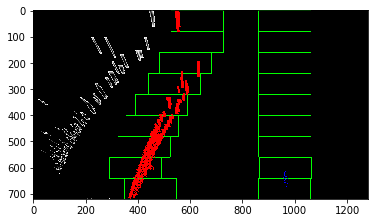

In [9]:


from moviepy.editor import VideoFileClip

clip1 = VideoFileClip('challenge_video.mp4').subclip(0,1)
output_clip = 'result_challenge_video.mp4'
pipe = Pipeline()
processed_clip = clip1.fl_image(pipe.pipeline)

%time processed_clip.write_videofile(output_clip, audio=False)


In [10]:
print (np.array(np.array([10, 11, 12])) - np.array([9, 2, 9]))

[1 9 3]